<a href="https://colab.research.google.com/github/maldisco/deep-learning_tomato_pest_classification/blob/main/tomato_pest_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("gdrive/My Drive/Colab Notebooks/proj2-fsi")

Mounted at /content/gdrive


# Preparando o dataset

Em primeiro lugar, todo o conjunto foi dividido em 90% treino, e 10% teste.
Nesse trecho de código, a parte de treino foi dividida em 70% treino e 30% validação.

In [2]:
import numpy as np
import tensorflow as tf
import glob

# Dimensão das imagens
IMG_DIM = (299,299)
BATCH_SIZE = 32

# Criação do dataset
# Alguns trechos foram retirados de https://chroniclesofai.com/transfer-learning-with-keras-resnet-50/

# Conjunto de treino
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "tomato-pest_train",
  labels="inferred",             # classes inferidas pelas subpastas do diretório
  label_mode="categorical",      
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=IMG_DIM,
  batch_size=BATCH_SIZE)
# Conjunto de validação
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "tomato-pest_train",
  labels="inferred",             
  label_mode="categorical",      
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=IMG_DIM,
  batch_size=BATCH_SIZE)

Found 3833 files belonging to 8 classes.
Using 2684 files for training.
Found 3833 files belonging to 8 classes.
Using 1149 files for validation.


# Visualização das imagens

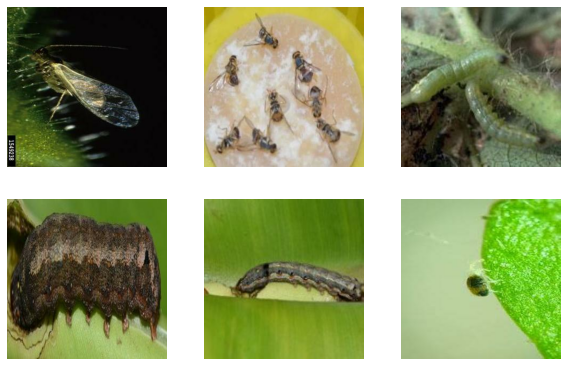

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

# Construindo o modelo pré-treinado utilizando a rede ResNET50

In [4]:
from keras.applications.resnet import ResNet50
import keras

# Alguns trechos foram retirados de 
# https://medium.com/@kenneth.ca95/a-guide-to-transfer-learning-with-keras-using-resnet50-a81a4a28084b
# e
# https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

# Formato da entrada
input_t = keras.Input(shape=(299,299,3))
# Modelo da rede resnet50
resnet_model = ResNet50(include_top=False, weights='imagenet', classes=8, input_tensor=input_t)

# Tornando (quase) todas as camadas da rede não-treináveis
for layer in resnet_model.layers[:143]: 
  layer.trainable=False

94781440/94765736 [==============================] - 1s 0us/step


### Composição do modelo

In [5]:
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers

# Dimensões de entrada da rede
input_shape=resnet_model.output_shape[1]

# Definição das camadas extras do modelo
out = resnet_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(126, activation='relu')(out)
out = Dropout(0.5)(out)                                    # Camada de dropout para evitar overfitting
predictions = Dense(8, activation='softmax')(out)
model = Model(inputs=resnet_model.input, outputs=predictions)

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=.0001), metrics=['accuracy'])

### Treinamento do modelo

In [6]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    batch_size=32,
                    epochs=10,
                    verbose=1)

model.save('tomato-plague_detection.h5')

Epoch 1/10
84/84 [==============================] - 362s 4s/step - loss: 1.0394 - accuracy: 0.6483 - val_loss: 0.8668 - val_accuracy: 0.7911
Epoch 2/10
84/84 [==============================] - 59s 701ms/step - loss: 0.2080 - accuracy: 0.9456 - val_loss: 0.2494 - val_accuracy: 0.9173
Epoch 3/10
84/84 [==============================] - 59s 698ms/step - loss: 0.0596 - accuracy: 0.9866 - val_loss: 0.2404 - val_accuracy: 0.9278
Epoch 4/10
84/84 [==============================] - 59s 700ms/step - loss: 0.0425 - accuracy: 0.9892 - val_loss: 0.1161 - val_accuracy: 0.9591
Epoch 5/10
84/84 [==============================] - 59s 699ms/step - loss: 0.0274 - accuracy: 0.9940 - val_loss: 0.1048 - val_accuracy: 0.9669
Epoch 6/10
84/84 [==============================] - 59s 698ms/step - loss: 0.0375 - accuracy: 0.9929 - val_loss: 0.1570 - val_accuracy: 0.9478
Epoch 7/10
84/84 [==============================] - 59s 699ms/step - loss: 0.0547 - accuracy: 0.9847 - val_loss: 0.1908 - val_accuracy: 0.9408
E

### Plotagem da história do modelo (Acurácia e perda)

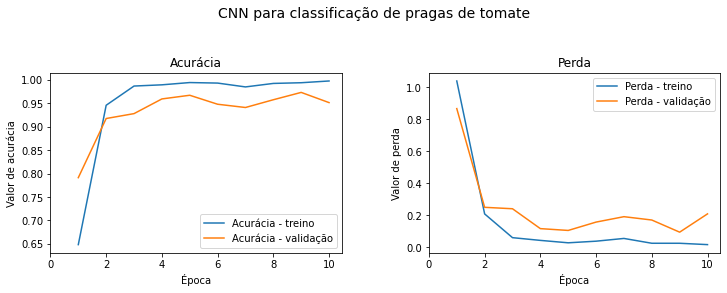

In [7]:
from matplotlib import pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN para classificação de pragas de tomate', fontsize=14)
f.subplots_adjust(top=0.75, wspace=0.3)

epoch_list = list(range(1,11))
# Acurácia
ax1.plot(epoch_list, history.history['accuracy'], label='Acurácia - treino')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Acurácia - validação')
ax1.set_xticks(np.arange(0, 11, 2))
ax1.set_ylabel('Valor de acurácia')
ax1.set_xlabel('Época')
ax1.set_title('Acurácia')
l1 = ax1.legend(loc="best")

# Perda
ax2.plot(epoch_list, history.history['loss'], label='Perda - treino')
ax2.plot(epoch_list, history.history['val_loss'], label='Perda - validação')
ax2.set_xticks(np.arange(0, 11, 2))
ax2.set_ylabel('Valor de perda')
ax2.set_xlabel('Época')
ax2.set_title('Perda')
l2 = ax2.legend(loc="best")

# Carregamento do modelo armazenado (opcional)

In [8]:
import keras
model = keras.models.load_model('tomato-plague_detection.h5')

# Predições e avaliações

### Função de avaliação

In [9]:
from sklearn.metrics import multilabel_confusion_matrix

def get_metrics(true_label, predictions, class_names):
    print(f"Classe    Acurácia    Revocação     F1")
    for name, cm in zip(class_names, multilabel_confusion_matrix(true_label, predictions)):
      tn, fn, tp, fp = cm[0][0], cm[1][0], cm[1][1], cm[0][1]
      accuracy = (tp+tn)/(tp+tn+fp+fn)
      sensitivity = tp/(tp+fn)
      precision = tp/(tp+fp)
      recall = tp/(tp+fn)
      f1 = 2*((precision*recall)/(precision+recall))
      print(f"{str(name).ljust(10)}{str(round(accuracy,5)).ljust(12)}{str(round(sensitivity,5)).ljust(14)}{str(round(f1,5)).ljust(5)}")

### Predições

Agora, restauramos os 10% de dados de teste para realizar predições e descobrir o poder de generalização da rede.

In [10]:
# Conjunto de teste
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "tomato-pest_test",
  labels="inferred",             
  label_mode="categorical",      
  seed=4,
  image_size=IMG_DIM,
  batch_size=BATCH_SIZE)

Found 430 files belonging to 8 classes.


In [11]:
true_label = []
predictions = []

# Iterando entre todo o conjunto de teste e extraindo as predições e labels
for img, label in test_ds.as_numpy_iterator():
  prediction = model.predict(img)
  predictions.extend(list(np.argmax(prediction, axis=1))) 
  true_label.extend(list(np.argmax(label, axis=1))) 

### Avaliação

Acurácia, revocação (ou sensitivity) e f1-score para cada uma das classes

In [12]:
class_names=['BA','HA','MP','SE','SI','TP','TU','ZC']
get_metrics(true_label, predictions, class_names)

Classe    Acurácia    Revocação     F1
BA        0.99535     1.0           0.97727
HA        0.98605     0.98684       0.96154
MP        0.97442     0.88043       0.93642
SE        0.97442     0.88679       0.89524
SI        0.96977     0.95588       0.90909
TP        0.99535     0.94118       0.94118
TU        0.99302     0.96078       0.9703
ZC        1.0         1.0           1.0  


# Relatório

As métricas de desempenho acima impressas indicam que a rede conseguiu ótimos resultados no conjunto disponível. Apesar da pequena quantidade de imagens, o pré-treino na rede resNET foi o suficiente para alcançar um bom nível de generalização.